# Information Points Extractor


## Who is Running?

In [212]:
#Matheus  
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto/Projeto_Final_DL"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## General Parâmeters

In [213]:
# Geneal parameters used on this notebook
study_case_name = "Pulsatrix_koeniswaldiana" #@param {type:"string"}
only_focus = True #@param {type:"boolean"}

# Parameters for Raster_Information_Collector
min_absence_distance = 100 #@param {type:"integer"

Fixed Parameters

In [214]:
# Geneal parameters used on this notebook
occurrences_root = project_root+"/Data/GBIF_Ocurrences"
brazil_coordinate_points = project_root + "/Data/Standarized_Brazil_Data/CSV_Aux_Files/brazil_coords.csv"

# Required parametes to instantiate Brazil
shapefiles_folder = project_root+'/Data/Shapefiles/Shapefiles_Brasil'
country_limits = (-73.981934,-34.792929, -33.750035, 5.271478)

# Parameters for Raster_Information_Collector
coorection_limit = 10
raster_information_collector_output_dir = project_root+"/Data/Rasters_As_Numpy_Arrays" 

#Parameters for Brazil
map_result_folder_path = project_root + "/Data/GBIF_Presence_Absence_Maps"

#Study Case Path
study_cases_root_folder = project_root+"/Data/Study_Cases"

# Main folder created on this file
presence_absence_folder_path = project_root + "/Data/Species_Presence_Absence"
species_env_info_folder_path = project_root + "/Data/Species_Enverionment_Info"

## Installs

In [215]:
! pip install geopandas --quiet
! pip install rasterio --quiet

## Retrieving aux Classes

In [216]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/raster_utils.py
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/brazil.py

--2021-01-12 23:47:41--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799 [text/plain]
Saving to: ‘utils.py.10’

utils.py.10         100%[===================>]     799  --.-KB/s    in 0s      

2021-01-12 23:47:41 (29.1 MB/s) - ‘utils.py.10’ saved [799/799]

--2021-01-12 23:47:41--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Utils/raster_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [217]:
from utils import Utils
from brazil import Brazil
from raster_utils import Raster_Utils

raster_utils = Raster_Utils()
utils_methods = Utils()
brazil_object= Brazil(shapefiles_folder = shapefiles_folder,
                      country_limits=country_limits)

## Getting Specie Study Data

In [218]:
import pandas as pd
import os
study_case_path =  os.path.join(study_cases_root_folder,study_case_name +'.csv')
study_information_df = pd.read_csv(study_case_path)
study_information_df

,GBIF_ID,Species_Name,Study_Focus
0,2497885,Pulsatrix koeniswaldiana,True


In [219]:
species_name = study_information_df[study_information_df['Study_Focus'] ==True]['Species_Name'][0]
taxonKey = study_information_df[study_information_df['Study_Focus'] ==True]['GBIF_ID'][0]
species_name_string = species_name.replace(" ","_")
print(f"species_name: {species_name} \ntaxonKey: {taxonKey} \nspecies_name_string: {species_name_string} \n ")

species_name: Pulsatrix koeniswaldiana 
taxonKey: 2497885 
species_name_string: Pulsatrix_koeniswaldiana 
 


## Creating Folder Structure

In [220]:
utils_methods.create_folder_structure(presence_absence_folder_path)
utils_methods.create_folder_structure(species_env_info_folder_path)

## Raster_Information_Collector


In [221]:
from typing import List,Tuple
import gc
from sklearn.utils import Bunch
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.windows import Window
from osgeo import gdal
import matplotlib.pyplot as plt
import geopy.distance
import os
import pandas as pd


class Raster_Information_Collector:
  """
  This class is reponsable for extracting data from rasters on GBIF occurrence locations

  Attributes
  ----------
  raster_base_configs : str
      Directory to save coverages
  coorection_limit : int
      Limit of iterations to correct no information points
  raster_utils : object
      Raster standards object
  """

  def __init__(self, output_dir:str,raster_utils,utils_methods,coorection_limit:int=10):
      """
      Parameters
      ----------
      raster_base_configs : str
          Directory to save coverages
      coorection_limit : int
          Limit of iterations to correct no information points
      raster_utils : object
          Raster standards object
      """

      self.output_dir = output_dir
      self.raster_utils = raster_utils
      self.coorection_limit = coorection_limit
      self.utils_methods = utils_methods

      self.species_presence_df = None
      self.species_absence_df = None
      self.env_info_species_presence_df = None
      self.env_info_species_absence_df = None


  def _fill_peristent_no_data_values_with_median_value(self,raster_occurrences_array):
      """ For grids that still with empty value after the board points treatment, this function fill it with the mean value"""

      median_value = np.median(raster_occurrences_array[[raster_occurrences_array!=self.raster_utils.no_data_val]])
      for i,elem in enumerate(raster_occurrences_array):
        if elem == self.raster_utils.no_data_val:
          raster_occurrences_array[i] = median_value
      
      return raster_occurrences_array


  def _get_coverage_from_coords(self,coordinates,list_raster_files,verbose):

    Lat = np.array([ t[0] for t in coordinates])
    Long =  np.array([ t[1] for t in coordinates])
    

    all_env_values_list = []
    for i,fp in enumerate(list_raster_files):

        if verbose:
          print(f"Reading raster {fp.split('/')[-1]}")

        # Exctraction occurences from rasters
        # In this process some small geograpichal erros are included on the form tiny of coordniate shift
        # While required because of an occasional error. Sometimes happens, sometimes not.
        raster_array,_,xgrid,ygrid,_,_ = self.raster_utils.get_raster_infos(fp)

        ix = np.searchsorted(xgrid,Long)
        iy = np.searchsorted(ygrid,Lat)

        if verbose:
          plt.imshow(raster_array, cmap='terrain')
          print('raster_array_shape :',raster_array.shape)
          plt.scatter(x=ix, y=4923-iy, c='r', s=10)
          # plt.scatter(x=4923-iy, y=ix, c='y', s=10)
          plt.show()
        raster_occurrences_array = raster_array[-iy, ix]#(N,)
        
        #treating cases where points that should be inside country are outside
        # raster_occurrences_array = self._treat_boarder_points(Long,Lat,ix,iy,raster_array,raster_occurrences_array)
        
        if verbose:
          #print(raster_occurrences_array)
          pass
          
        del raster_array

        #tretaing cases that still with no data values
        #it is not the best solutions. But its seams ok
        raster_occurrences_array= self._fill_peristent_no_data_values_with_median_value(raster_occurrences_array)
        
        #selecting the env value on the occurrence position
        all_env_values_list.append(raster_occurrences_array)

        del raster_occurrences_array
        del ix
        del iy
        gc.collect()

    coverage= np.stack([value for value in all_env_values_list]).T
    del all_env_values_list
    gc.collect() 

    print("------------------------------------------------------\n")
    return coverage


  def _get_distance_between_coords_in_km(self,coords_1:Tuple,coords_2:Tuple):
    return geopy.distance.vincenty(coords_1, coords_2).km

 
  def create_species_presence_df(self,specie_dir:str,species_name:str):

    species_presence_df = gpd.read_file(specie_dir)
    species_presence_df = species_presence_df[['LONGITUDE','LATITUDE']]
    species_presence_df['coords'] = species_presence_df[['LATITUDE', 'LONGITUDE']].apply(tuple, axis=1) 
    species_presence_df['presence/pseudo_absence'] = 1
    presence_absence_folder_path_species = f"{presence_absence_folder_path}/{species_name}"
    self.utils_methods.create_folder_structure(presence_absence_folder_path_species)
    final_path = f"{presence_absence_folder_path_species}/{species_name}_presence.csv"
    species_presence_df.to_csv(final_path,index = False, header=True)
    self.species_presence_df = species_presence_df
    
    return species_presence_df,final_path


  
  def create_env_info_species_presence_df(self,
                                          species_name:str,
                                          list_raster_files:List[str],
                                          list_names_raster:List[str],
                                          presence_absence_folder_path:str,
                                          species_env_info_folder_path:str,
                                          verbose:bool=False):
    
    """ Save all extracted to a numpy array"""
    if self.species_presence_df is None:
      raise Exception("You must read the presence dataframe before")

    coordinates = self.species_presence_df['coords'].to_numpy()
    coverage = self._get_coverage_from_coords(coordinates,list_raster_files,verbose)

    species_numpy_array_folder_path = f"{self.output_dir}/{species_name}"
    self.utils_methods.create_folder_structure(species_numpy_array_folder_path)
    self.utils_methods.save_nparray_to_folder(coverage,species_numpy_array_folder_path,f"{species_name}_presence")

    with open(f"{self.output_dir}/{species_name}/{species_name}_presence.npy", 'rb') as f:
            numpy_raster_info = np.load(f)
            env_info_species_presence_df = pd.DataFrame(numpy_raster_info,columns = list_names_raster)
            species_env_info_folder = f"{species_env_info_folder_path}/{species_name}"
            self.utils_methods.create_folder_structure(species_env_info_folder)
            final_path = f"{species_env_info_folder}/{species_name}_presence.csv"
            env_info_species_presence_df.to_csv(final_path,index = False, header=True)
            
    del coverage
    gc.collect()

    self.env_info_species_presence_df = env_info_species_presence_df

    return env_info_species_presence_df,final_path
  
  
  def create_species_absence_df(self,
                                species_name:str,
                                min_absence_distance:int,
                                presence_absence_folder_path:str,
                                brazil_coordinate_points_path:str,
                                verbose = False):
    

    # RETRIEVING NECESSARY DATAFRAMES
    df_species_occurrences = self.species_presence_df 
    df_species_env_info = self.env_info_species_presence_df
    df_brazil_coordinate_points = pd.read_csv(brazil_coordinate_points_path)
    df_brazil_coordinate_points['coords'] = list(zip(df_brazil_coordinate_points.latitude, df_brazil_coordinate_points.longitude))

    # ABSENCE OCURRENCES 
    df_brazil_coordinate_points_copy = df_brazil_coordinate_points.copy()
    df_brazil_coordinate_points_copy = df_brazil_coordinate_points_copy.sample(frac = 1) 
    number_of_presences = len(df_species_occurrences)
    number_of_absences = number_of_presences if number_of_presences < 2000 else 2000
    abs_row = 0
    dict_absences = {}
    while number_of_absences>0:
      step_reduction = 0
      # Recuperando uma parcela de todos os pontos possíveis
      df_brazil_possible_absence_points = df_brazil_coordinate_points_copy[:number_of_absences]
      # Iterando sobre os possíveis pontos de absência
      for i,row1 in df_brazil_possible_absence_points.iterrows():
        possible_coord = row1['coords']
        # Iterando sobre os pontos de presença já conhecindos
        for k,row2 in df_species_occurrences.iterrows():
          presence_coord = (row2['LATITUDE'],row2['LONGITUDE'])
          dist = self._get_distance_between_coords_in_km(presence_coord,possible_coord)
          if dist<min_absence_distance:
            if verbose:
              print(f"The coord {possible_coord} is not valid")
            possible_coord = None
            df_brazil_coordinate_points_copy = df_brazil_coordinate_points_copy.drop([i])
            df_brazil_possible_absence_points = df_brazil_possible_absence_points.drop([i])
            break
        if possible_coord:
          if verbose:
            print(f"The coord {possible_coord} is VALID")
          dict_absences[abs_row] = {'LONGITUDE':possible_coord[1], 'LATITUDE':possible_coord[0], 'coords': possible_coord,'presence/pseudo_absence':0}
          abs_row+=1
          step_reduction+=1

      number_of_absences = number_of_absences-step_reduction
      if verbose:
        print(f"{number_of_absences} absence points stills need to found")
      

    df_absences = pd.DataFrame.from_dict(dict_absences, "index") 
    presence_absence_folder_path_species = f"{presence_absence_folder_path}/{species_name}"
    self.utils_methods.create_folder_structure(presence_absence_folder_path_species)
    final_path = f"{presence_absence_folder_path_species}/{species_name}_absence.csv"
    df_absences.to_csv(final_path,index = False, header=True)
    self.species_absence_df = df_absences

    return df_absences,final_path

  def create_env_info_species_absence_df(self,
                                         species_name:str,
                                         list_raster_files:List[str],
                                         list_names_raster:List[str],
                                         presence_absence_folder_path:str,
                                         species_env_info_folder_path:str,
                                         verbose:bool=False):
    
    if self.species_absence_df is None:
      raise Exception("You must read the absence dataframe before")
    
    species_absence_df= self.species_absence_df
    coordinates = self.species_absence_df['coords'].to_numpy()
    coverage = self._get_coverage_from_coords(coordinates,list_raster_files,verbose)

    species_numpy_array_folder_path = f"{self.output_dir}/{species_name}"
    self.utils_methods.create_folder_structure(species_numpy_array_folder_path)
    self.utils_methods.save_nparray_to_folder(coverage,species_numpy_array_folder_path,f"{species_name}_absence")

    with open(f"{self.output_dir}/{species_name}/{species_name}_absence.npy", 'rb') as f:
            numpy_raster_info = np.load(f)
            env_info_species_absence_df = pd.DataFrame(numpy_raster_info,columns = list_names_raster)
            species_env_info_folder = f"{species_env_info_folder_path}/{species_name}"
            self.utils_methods.create_folder_structure(species_env_info_folder)
            final_path = f"{species_env_info_folder}/{species_name}_absence.csv"
            env_info_species_absence_df.to_csv(final_path,index = False, header=True)
    
    del coverage
    gc.collect()

    self.env_info_species_absence_df =  env_info_species_absence_df

    return env_info_species_absence_df,final_path

  def reset_dataframes(self):
      self.species_presence_df = None
      self.species_absence_df = None
      self.env_info_species_presence_df = None
      self.env_info_species_absence_df = None

## Creating Instances

Creating collector instance

In [222]:
raster_collector = Raster_Information_Collector(output_dir=raster_information_collector_output_dir,
                                                raster_utils=raster_utils,
                                                utils_methods=utils_methods,
                                                coorection_limit=coorection_limit)

Retrieving list of rasters

In [223]:
list_raster_files = open(project_root + '/Data/Standarized_Brazil_Data/TXT_Aux_Files/list_raster_files.txt', 'r').read().splitlines()
list_names_raster = open(project_root + '/Data/Standarized_Brazil_Data/TXT_Aux_Files/list_names_raster.txt', 'r').read().splitlines()

## Getting and Saving PRESENCE data

In [224]:
specie_shp_path = os.path.join(occurrences_root,species_name_string,species_name_string+".shp")
species_presence_df,species_presence_path = raster_collector.create_species_presence_df(specie_dir = specie_shp_path,
                                                 species_name = species_name_string)
species_presence_df

,LONGITUDE,LATITUDE,coords,presence/pseudo_absence
0,-40.526700,-15.790900,"(-15.7909, -40.5267)",1
1,-39.967300,-16.351400,"(-16.3514, -39.9673)",1
2,-40.526600,-15.790800,"(-15.7908, -40.5266)",1
3,-39.169800,-16.387600,"(-16.3876, -39.1698)",1
4,-39.169800,-16.387600,"(-16.3876, -39.1698)",1
...,...,...,...,...
1344,-48.433400,-24.283400,"(-24.2834, -48.4334)",1
1345,-44.583333,-22.416667,"(-22.416667, -44.583333)",1
1346,-45.100000,-23.466667,"(-23.466667, -45.1)",1
1347,-44.583333,-22.416667,"(-22.416667, -44.583333)",1


Reading raster bio1_annual_mean_temperature.tif
Reading raster bio1_annual_mean_temperature.tif
raster_array_shape : (4923, 4942)


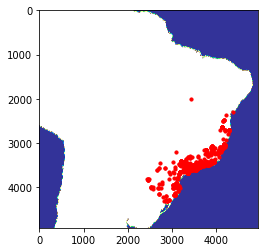

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Reading raster bio2_mean_diurnal_range.tif
Reading raster bio2_mean_diurnal_range.tif
raster_array_shape : (4923, 4942)


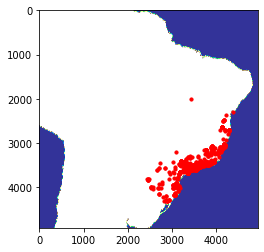

Reading raster bio3_isothermality.tif
Reading raster bio3_isothermality.tif
raster_array_shape : (4923, 4942)


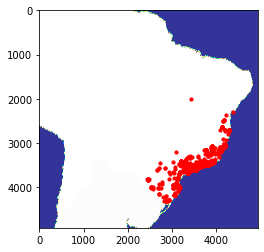

Reading raster bio4_temperature_seasonality.tif
Reading raster bio4_temperature_seasonality.tif
raster_array_shape : (4923, 4942)


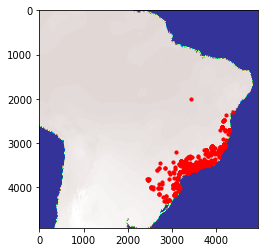

Reading raster bio5_max_temperature_of_warmest_month.tif
Reading raster bio5_max_temperature_of_warmest_month.tif
raster_array_shape : (4923, 4942)


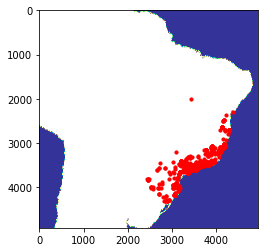

Reading raster bio6_min_temperature_of_coldest_month.tif
Reading raster bio6_min_temperature_of_coldest_month.tif
raster_array_shape : (4923, 4942)


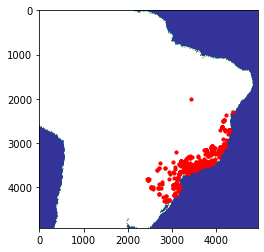

Reading raster bio7_temperature_annual_range.tif
Reading raster bio7_temperature_annual_range.tif
raster_array_shape : (4923, 4942)


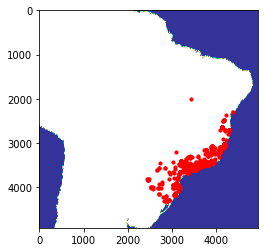

Reading raster bio8_mean_temperature_of_wettest_quarter.tif
Reading raster bio8_mean_temperature_of_wettest_quarter.tif
raster_array_shape : (4923, 4942)


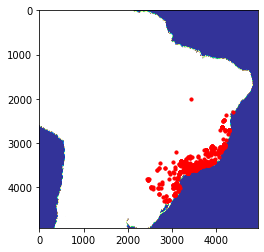

Reading raster bio9_mean_temperature_of_driest_quarter.tif
Reading raster bio9_mean_temperature_of_driest_quarter.tif
raster_array_shape : (4923, 4942)


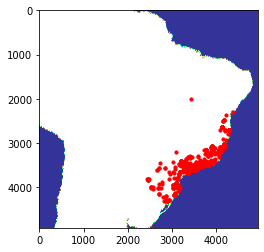

Reading raster bio10_mean_temperature_of_warmest_quarter.tif
Reading raster bio10_mean_temperature_of_warmest_quarter.tif
raster_array_shape : (4923, 4942)


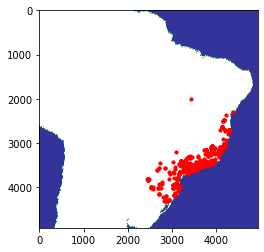

Reading raster bio11_mean_temperature_of_coldest_quarter.tif
Reading raster bio11_mean_temperature_of_coldest_quarter.tif
raster_array_shape : (4923, 4942)


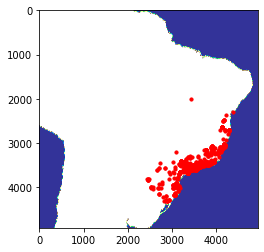

Reading raster bio12_annual_precipitation.tif
Reading raster bio12_annual_precipitation.tif
raster_array_shape : (4923, 4942)


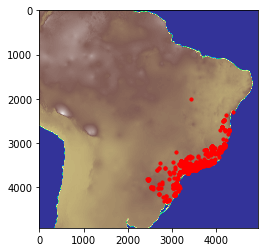

Reading raster bio13_precipitation_of_wettest_month.tif
Reading raster bio13_precipitation_of_wettest_month.tif
raster_array_shape : (4923, 4942)


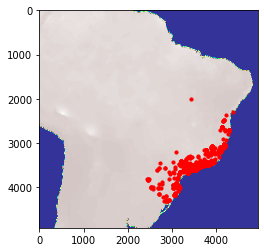

Reading raster bio14_precipitation_of_driest_month.tif
Reading raster bio14_precipitation_of_driest_month.tif
raster_array_shape : (4923, 4942)


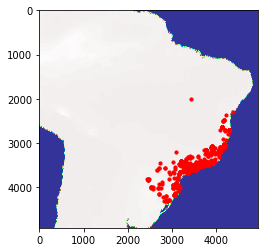

Reading raster bio15_precipitation_seasonality.tif
Reading raster bio15_precipitation_seasonality.tif
raster_array_shape : (4923, 4942)


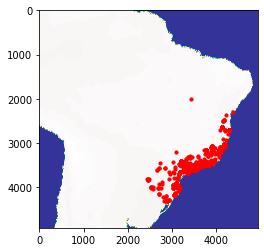

Reading raster bio16_precipitation_of_wettest_quarter.tif
Reading raster bio16_precipitation_of_wettest_quarter.tif
raster_array_shape : (4923, 4942)


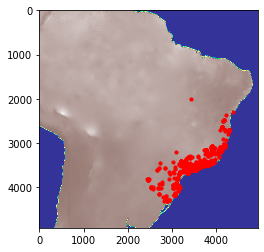

Reading raster bio17_precipitation_of_driest_quarter.tif
Reading raster bio17_precipitation_of_driest_quarter.tif
raster_array_shape : (4923, 4942)


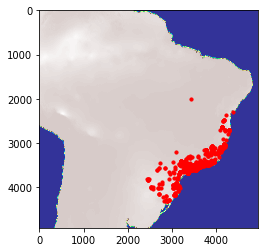

Reading raster bio18_precipitation_of_warmest_quarter.tif
Reading raster bio18_precipitation_of_warmest_quarter.tif
raster_array_shape : (4923, 4942)


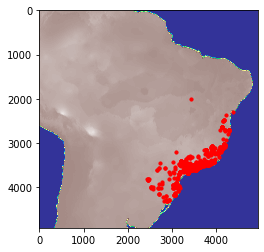

Reading raster bio19_precipitation_of_coldest_quarter.tif
Reading raster bio19_precipitation_of_coldest_quarter.tif
raster_array_shape : (4923, 4942)


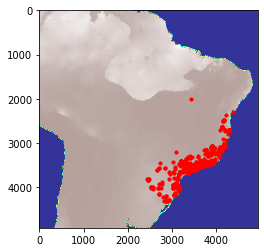

Reading raster elev1_strm_worldclim_elevation.tif
Reading raster elev1_strm_worldclim_elevation.tif
raster_array_shape : (4923, 4942)


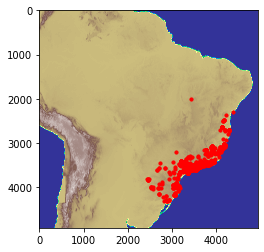

Reading raster elev2_envirem_terrain_roughness_index.tif
Reading raster elev2_envirem_terrain_roughness_index.tif
raster_array_shape : (4923, 4942)


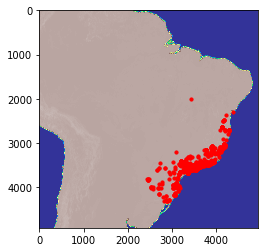

Reading raster elev3_envirem_topographic_wetness_index.tif
Reading raster elev3_envirem_topographic_wetness_index.tif
raster_array_shape : (4923, 4942)


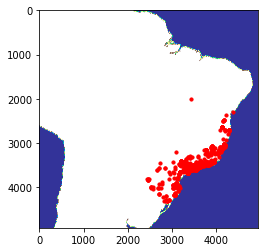

Reading raster envir1_annual_PET.tif
Reading raster envir1_annual_PET.tif
raster_array_shape : (4923, 4942)


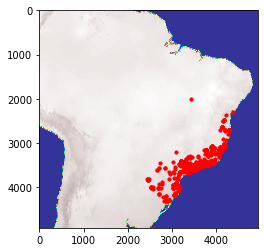

Reading raster envir2_aridity_index_thornthwaite.tif
Reading raster envir2_aridity_index_thornthwaite.tif
raster_array_shape : (4923, 4942)


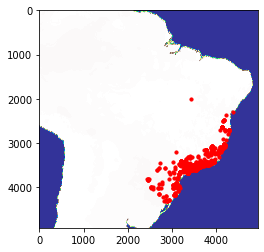

Reading raster envir3_climatic_moisture_index.tif
Reading raster envir3_climatic_moisture_index.tif
raster_array_shape : (4923, 4942)


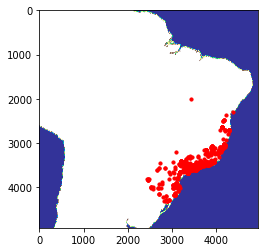

Reading raster envir4_continentality.tif
Reading raster envir4_continentality.tif
raster_array_shape : (4923, 4942)


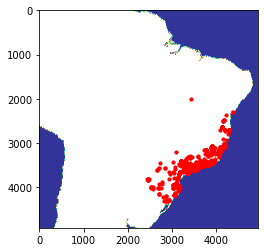

Reading raster envir5_embergers_pluviothermic_quotient.tif
Reading raster envir5_embergers_pluviothermic_quotient.tif
raster_array_shape : (4923, 4942)


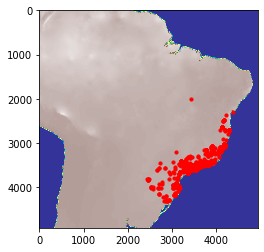

Reading raster envir6_growing_deg_days_0.tif
Reading raster envir6_growing_deg_days_0.tif
raster_array_shape : (4923, 4942)


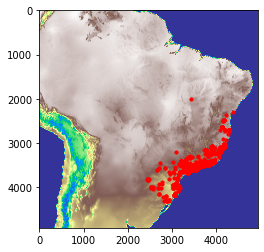

Reading raster envir7_growing_deg_days_5.tif
Reading raster envir7_growing_deg_days_5.tif
raster_array_shape : (4923, 4942)


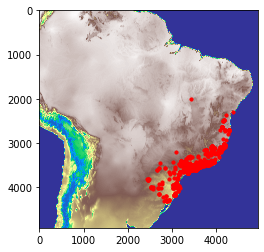

Reading raster envir8_max_temp_coldest.tif
Reading raster envir8_max_temp_coldest.tif
raster_array_shape : (4923, 4942)


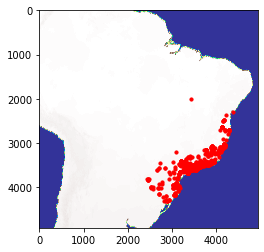

Reading raster envir9_min_temp_warmest.tif
Reading raster envir9_min_temp_warmest.tif
raster_array_shape : (4923, 4942)


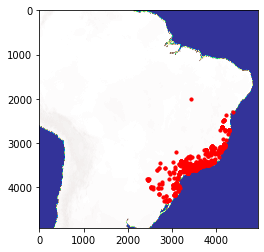

Reading raster envir10_month_count_by_temp_10.tif
Reading raster envir10_month_count_by_temp_10.tif
raster_array_shape : (4923, 4942)


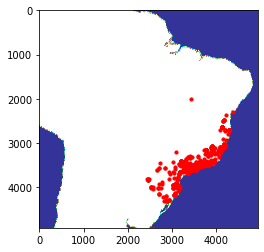

Reading raster envir11_PET_coldest_quarter.tif
Reading raster envir11_PET_coldest_quarter.tif
raster_array_shape : (4923, 4942)


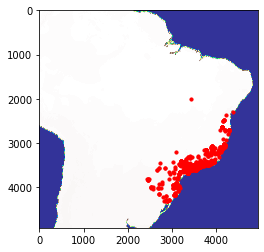

Reading raster envir12_PET_driest_quarter.tif
Reading raster envir12_PET_driest_quarter.tif
raster_array_shape : (4923, 4942)


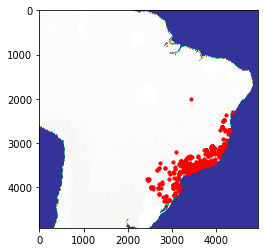

Reading raster envir13_PET_seasonality.tif
Reading raster envir13_PET_seasonality.tif
raster_array_shape : (4923, 4942)


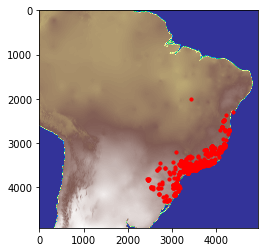

Reading raster envir14_PET_warmest_quarter.tif
Reading raster envir14_PET_warmest_quarter.tif
raster_array_shape : (4923, 4942)


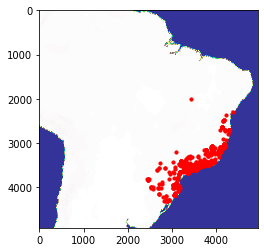

Reading raster envir15_PET_wettest_quarter.tif
Reading raster envir15_PET_wettest_quarter.tif
raster_array_shape : (4923, 4942)


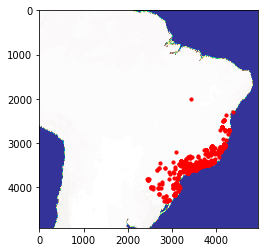

Reading raster envir16_thermicity_index.tif
Reading raster envir16_thermicity_index.tif
raster_array_shape : (4923, 4942)


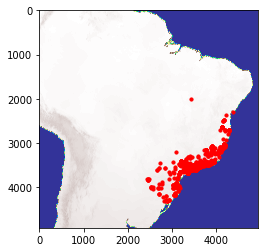

------------------------------------------------------

Pulsatrix_koeniswaldiana_presence Shape:  (1349, 38)


In [225]:
env_info_species_presence_df,env_info_species_presence_path = raster_collector.create_env_info_species_presence_df(species_name=species_name_string,
                                                                   list_raster_files=list_raster_files,
                                                                   list_names_raster=list_names_raster,
                                                                   presence_absence_folder_path=presence_absence_folder_path,
                                                                   species_env_info_folder_path=species_env_info_folder_path,
                                                                   verbose = True)

## Getting and Saving ABSENCE data

In [226]:
species_absence_df,species_absence_path = raster_collector.create_species_absence_df(species_name = species_name_string,
                      min_absence_distance = min_absence_distance,
                      presence_absence_folder_path = presence_absence_folder_path,
                      brazil_coordinate_points_path = brazil_coordinate_points,
                      verbose = True)

The coord (-16.820188666666667, -54.69860066666665) is VALID
The coord (-13.586855333333334, -59.33193399999998) is VALID
The coord (-20.83685533333333, -57.38193399999998) is VALID
The coord (-0.9201886666666664, -57.04026733333332) is VALID
The coord (-22.52018866666667, -48.32360066666664) is not valid
The coord (-14.636855333333333, -40.72360066666664) is not valid
The coord (-10.086855333333334, -58.881933999999994) is VALID
The coord (-8.728522, -40.33193399999997) is VALID
The coord (-5.553521999999999, -59.248600666666654) is VALID
The coord (-3.6785219999999987, -46.81526733333331) is VALID
The coord (-28.970188666666665, -53.75693399999998) is VALID
The coord (-17.48685533333333, -50.21526733333331) is VALID
The coord (-8.936855333333334, -51.740267333333314) is VALID
The coord (2.296478, -61.123600666666654) is VALID
The coord (-24.153522, -46.77360066666664) is not valid
The coord (-12.411855333333332, -58.46526733333332) is VALID
The coord (1.1214779999999998, -55.54860066

In [227]:
species_absence_df

,LONGITUDE,LATITUDE,coords,presence/pseudo_absence
0,-54.698601,-16.820189,"(-16.820188666666667, -54.69860066666665)",0
1,-59.331934,-13.586855,"(-13.586855333333334, -59.33193399999998)",0
2,-57.381934,-20.836855,"(-20.83685533333333, -57.38193399999998)",0
3,-57.040267,-0.920189,"(-0.9201886666666664, -57.04026733333332)",0
4,-58.881934,-10.086855,"(-10.086855333333334, -58.881933999999994)",0
...,...,...,...,...
1344,-46.606934,-8.586855,"(-8.586855333333332, -46.606933999999974)",0
1345,-70.023601,-8.186855,"(-8.186855333333334, -70.02360066666665)",0
1346,-44.006934,-13.911855,"(-13.911855333333332, -44.00693399999997)",0
1347,-46.681934,-9.286855,"(-9.286855333333332, -46.68193399999997)",0


Reading raster bio1_annual_mean_temperature.tif
Reading raster bio1_annual_mean_temperature.tif
raster_array_shape : (4923, 4942)


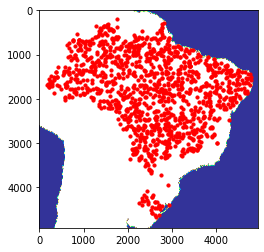

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Reading raster bio2_mean_diurnal_range.tif
Reading raster bio2_mean_diurnal_range.tif
raster_array_shape : (4923, 4942)


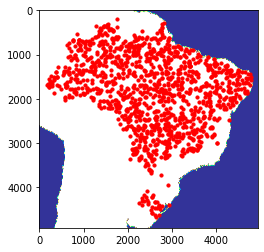

Reading raster bio3_isothermality.tif
Reading raster bio3_isothermality.tif
raster_array_shape : (4923, 4942)


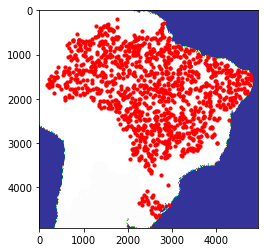

Reading raster bio4_temperature_seasonality.tif
Reading raster bio4_temperature_seasonality.tif
raster_array_shape : (4923, 4942)


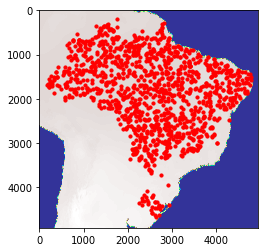

Reading raster bio5_max_temperature_of_warmest_month.tif
Reading raster bio5_max_temperature_of_warmest_month.tif
raster_array_shape : (4923, 4942)


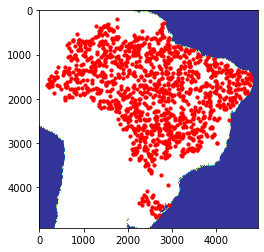

Reading raster bio6_min_temperature_of_coldest_month.tif
Reading raster bio6_min_temperature_of_coldest_month.tif
raster_array_shape : (4923, 4942)


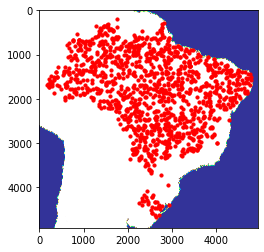

Reading raster bio7_temperature_annual_range.tif
Reading raster bio7_temperature_annual_range.tif
raster_array_shape : (4923, 4942)


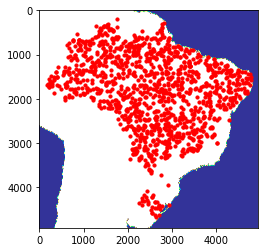

Reading raster bio8_mean_temperature_of_wettest_quarter.tif
Reading raster bio8_mean_temperature_of_wettest_quarter.tif
raster_array_shape : (4923, 4942)


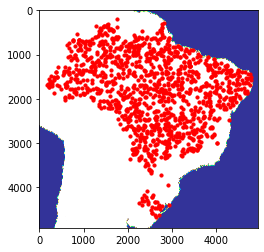

Reading raster bio9_mean_temperature_of_driest_quarter.tif
Reading raster bio9_mean_temperature_of_driest_quarter.tif
raster_array_shape : (4923, 4942)


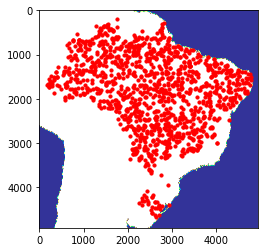

Reading raster bio10_mean_temperature_of_warmest_quarter.tif
Reading raster bio10_mean_temperature_of_warmest_quarter.tif
raster_array_shape : (4923, 4942)


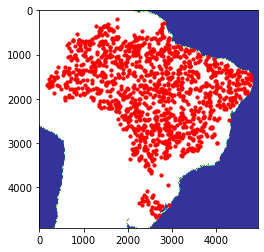

Reading raster bio11_mean_temperature_of_coldest_quarter.tif
Reading raster bio11_mean_temperature_of_coldest_quarter.tif
raster_array_shape : (4923, 4942)


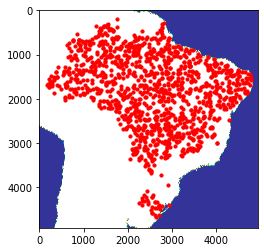

Reading raster bio12_annual_precipitation.tif
Reading raster bio12_annual_precipitation.tif
raster_array_shape : (4923, 4942)


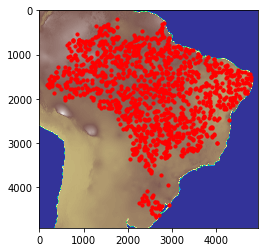

Reading raster bio13_precipitation_of_wettest_month.tif
Reading raster bio13_precipitation_of_wettest_month.tif
raster_array_shape : (4923, 4942)


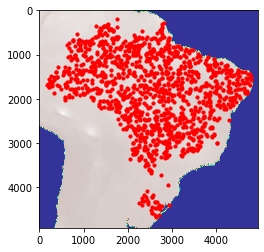

Reading raster bio14_precipitation_of_driest_month.tif
Reading raster bio14_precipitation_of_driest_month.tif
raster_array_shape : (4923, 4942)


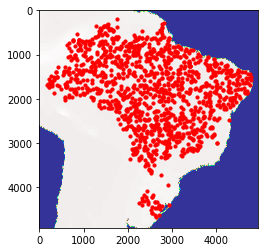

Reading raster bio15_precipitation_seasonality.tif
Reading raster bio15_precipitation_seasonality.tif
raster_array_shape : (4923, 4942)


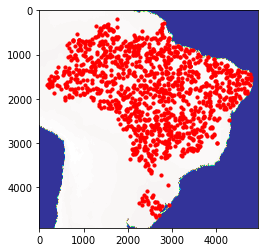

Reading raster bio16_precipitation_of_wettest_quarter.tif
Reading raster bio16_precipitation_of_wettest_quarter.tif
raster_array_shape : (4923, 4942)


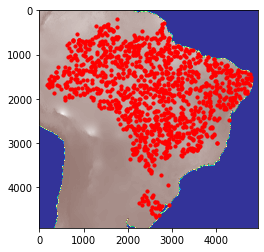

Reading raster bio17_precipitation_of_driest_quarter.tif
Reading raster bio17_precipitation_of_driest_quarter.tif
raster_array_shape : (4923, 4942)


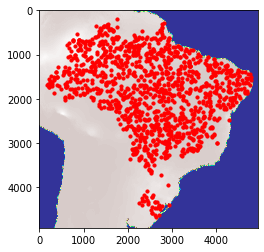

Reading raster bio18_precipitation_of_warmest_quarter.tif
Reading raster bio18_precipitation_of_warmest_quarter.tif
raster_array_shape : (4923, 4942)


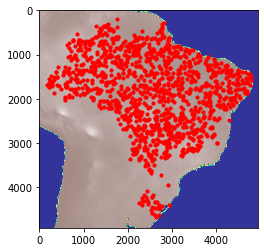

Reading raster bio19_precipitation_of_coldest_quarter.tif
Reading raster bio19_precipitation_of_coldest_quarter.tif
raster_array_shape : (4923, 4942)


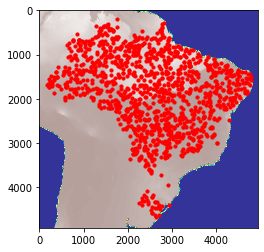

Reading raster elev1_strm_worldclim_elevation.tif
Reading raster elev1_strm_worldclim_elevation.tif
raster_array_shape : (4923, 4942)


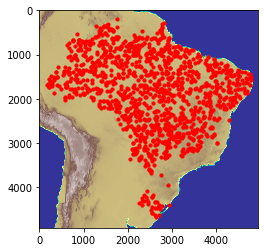

Reading raster elev2_envirem_terrain_roughness_index.tif
Reading raster elev2_envirem_terrain_roughness_index.tif
raster_array_shape : (4923, 4942)


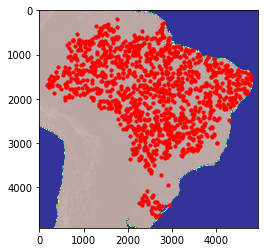

Reading raster elev3_envirem_topographic_wetness_index.tif
Reading raster elev3_envirem_topographic_wetness_index.tif
raster_array_shape : (4923, 4942)


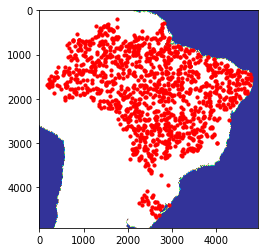

Reading raster envir1_annual_PET.tif
Reading raster envir1_annual_PET.tif
raster_array_shape : (4923, 4942)


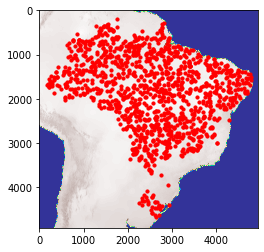

Reading raster envir2_aridity_index_thornthwaite.tif
Reading raster envir2_aridity_index_thornthwaite.tif
raster_array_shape : (4923, 4942)


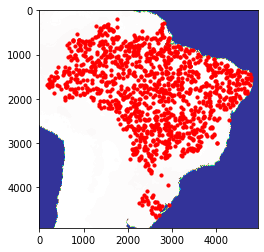

Reading raster envir3_climatic_moisture_index.tif
Reading raster envir3_climatic_moisture_index.tif
raster_array_shape : (4923, 4942)


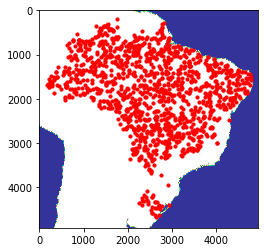

Reading raster envir4_continentality.tif
Reading raster envir4_continentality.tif
raster_array_shape : (4923, 4942)


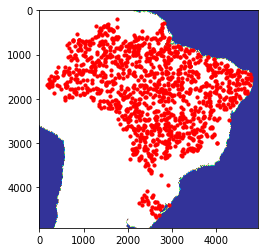

Reading raster envir5_embergers_pluviothermic_quotient.tif
Reading raster envir5_embergers_pluviothermic_quotient.tif
raster_array_shape : (4923, 4942)


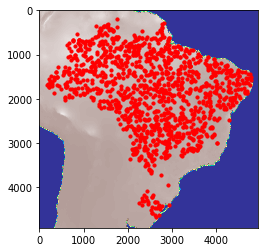

Reading raster envir6_growing_deg_days_0.tif
Reading raster envir6_growing_deg_days_0.tif
raster_array_shape : (4923, 4942)


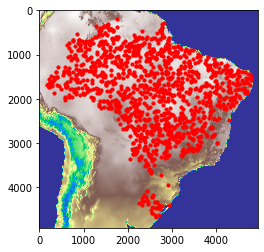

Reading raster envir7_growing_deg_days_5.tif
Reading raster envir7_growing_deg_days_5.tif
raster_array_shape : (4923, 4942)


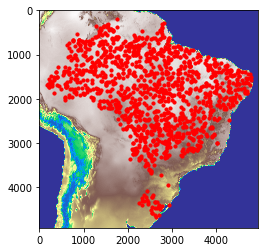

Reading raster envir8_max_temp_coldest.tif
Reading raster envir8_max_temp_coldest.tif
raster_array_shape : (4923, 4942)


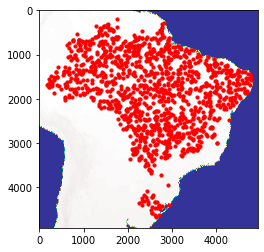

Reading raster envir9_min_temp_warmest.tif
Reading raster envir9_min_temp_warmest.tif
raster_array_shape : (4923, 4942)


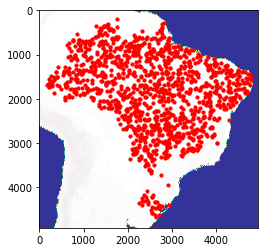

Reading raster envir10_month_count_by_temp_10.tif
Reading raster envir10_month_count_by_temp_10.tif
raster_array_shape : (4923, 4942)


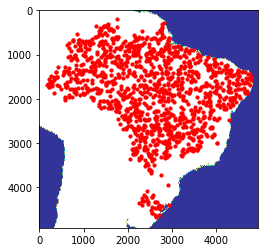

Reading raster envir11_PET_coldest_quarter.tif
Reading raster envir11_PET_coldest_quarter.tif
raster_array_shape : (4923, 4942)


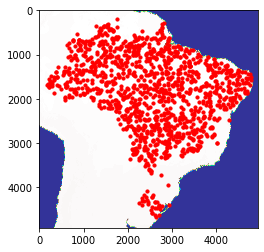

Reading raster envir12_PET_driest_quarter.tif
Reading raster envir12_PET_driest_quarter.tif
raster_array_shape : (4923, 4942)


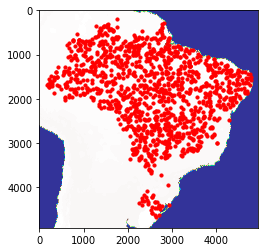

Reading raster envir13_PET_seasonality.tif
Reading raster envir13_PET_seasonality.tif
raster_array_shape : (4923, 4942)


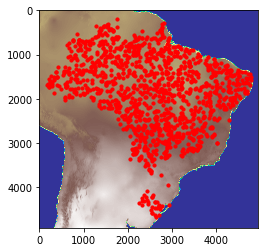

Reading raster envir14_PET_warmest_quarter.tif
Reading raster envir14_PET_warmest_quarter.tif
raster_array_shape : (4923, 4942)


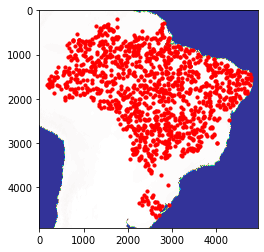

Reading raster envir15_PET_wettest_quarter.tif
Reading raster envir15_PET_wettest_quarter.tif
raster_array_shape : (4923, 4942)


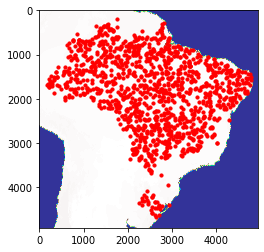

Reading raster envir16_thermicity_index.tif
Reading raster envir16_thermicity_index.tif
raster_array_shape : (4923, 4942)


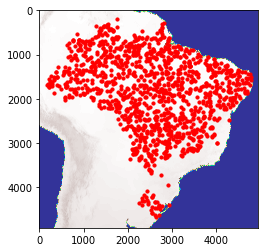

------------------------------------------------------

Pulsatrix_koeniswaldiana_absence Shape:  (1349, 38)


In [228]:
env_info_species_absence_df,env_info_species_absence_path = raster_collector.create_env_info_species_absence_df(species_name= species_name_string,
                                   list_raster_files=list_raster_files,
                                   list_names_raster=list_names_raster,
                                   presence_absence_folder_path = presence_absence_folder_path,
                                   species_env_info_folder_path = species_env_info_folder_path,
                                   verbose = True)


In [229]:
env_info_species_absence_df

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,23.475000,13.083333,65.416672,182.949310,32.099998,12.100000,19.999998,24.683334,20.850000,25.016666,20.850000,1570.0,275.0,14.0,72.780296,748.0,52.0,587.0,52.0,453.0,16.25,11.60,1739.150024,59.209999,-0.13,4.35,269.290009,103392.0,103392.0,283.0,183.0,12.0,113.209999,120.180000,2288.229980,165.649994,162.500000,609.5
1,23.570833,13.758333,68.791664,103.450859,32.400002,12.400000,20.000002,24.016666,22.266666,24.549999,22.000000,1966.0,332.0,11.0,73.135475,919.0,61.0,446.0,99.0,628.0,21.25,11.68,1727.829956,56.669998,0.12,2.80,349.859985,94914.0,94914.0,290.0,162.0,12.0,121.680000,130.860001,1636.390015,161.830002,147.270004,562.0
2,25.054167,11.591667,61.008778,273.865082,33.299999,14.300000,19.000000,27.716667,21.450001,27.833332,21.433332,1160.0,165.0,36.0,47.176479,462.0,120.0,455.0,161.0,109.0,4.00,12.19,1710.400024,28.670000,-0.29,7.30,217.979996,108882.0,108882.0,267.0,225.0,12.0,92.690002,98.160004,3742.979980,181.509995,184.100006,653.0
3,26.924999,8.616667,79.051971,60.659260,32.900002,22.000000,10.900002,26.549999,27.100000,27.816666,26.383333,2624.0,398.0,94.0,50.077881,1145.0,341.0,385.0,887.0,55.0,27.75,10.91,1664.520020,23.180000,0.36,1.65,771.349976,118620.0,118620.0,309.0,232.0,12.0,133.750000,154.309998,1215.060059,154.309998,129.990005,736.5
4,25.700001,11.966666,68.773956,45.974323,34.099998,16.700001,17.399998,25.600000,25.316666,26.216667,25.133333,1952.0,325.0,5.0,76.186920,939.0,43.0,235.0,83.0,163.0,4.62,11.88,1822.290039,65.919998,0.07,1.75,352.890015,108900.0,108900.0,329.0,187.0,12.0,138.029999,149.500000,1348.739990,169.110001,148.229996,663.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,24.279167,12.608334,69.276558,78.290215,33.500000,15.300000,18.200001,23.683334,24.049999,25.433334,23.683334,1286.0,209.0,3.0,76.977425,585.0,21.0,172.0,585.0,520.0,5.25,13.19,1787.949951,68.220001,-0.29,1.85,258.880005,108216.0,108216.0,319.0,196.0,12.0,139.990005,147.320007,873.049988,160.550003,144.039993,665.5
1345,24.783333,10.850000,79.779411,61.730122,30.900000,17.299999,13.600000,25.183334,23.850000,25.316666,23.850000,2236.0,298.0,49.0,52.146191,833.0,168.0,728.0,168.0,210.0,5.12,12.91,1750.880005,55.189999,0.24,1.55,557.150024,109944.0,109944.0,308.0,206.0,12.0,129.949997,135.669998,1102.339966,155.649994,151.080002,667.5
1346,24.533333,12.350000,70.571426,120.723839,32.700001,15.200000,17.500000,25.066668,22.900000,25.799999,22.866667,844.0,181.0,1.0,94.614761,480.0,3.0,248.0,9.0,480.0,3.12,11.14,1791.469971,60.660000,-0.54,3.80,157.910004,106164.0,106164.0,297.0,200.0,12.0,122.190002,128.270004,1904.089966,167.110001,164.229996,642.0
1347,24.329166,12.825000,68.951614,80.126549,33.700001,15.100000,18.6000

## Plottig the points on the map

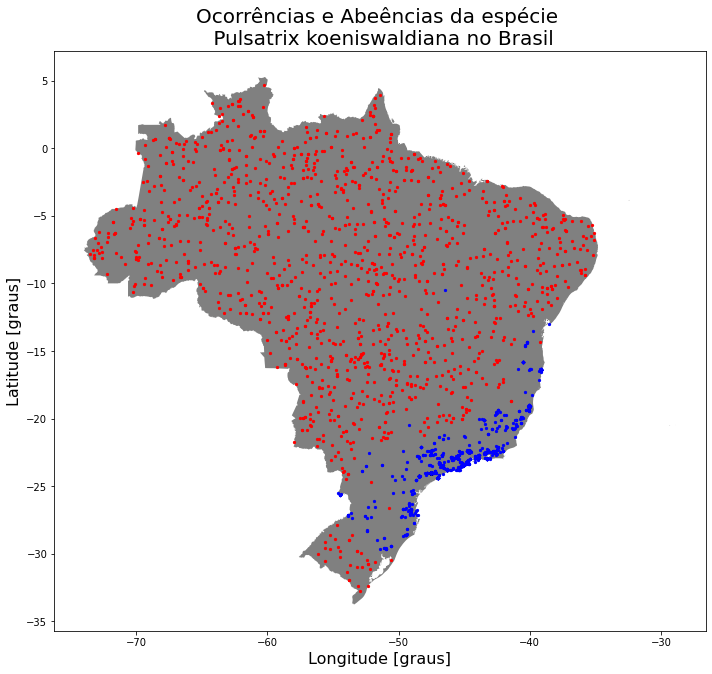

In [230]:
map_result_species_folder_path = os.path.join(map_result_folder_path,species_name_string)
utils_methods.create_folder_structure(map_result_species_folder_path)

brazil_object.plot_points_on_country(species_name=species_name,
                              map_result_path = f"{map_result_species_folder_path}/{species_name_string}.png",
                              species_presences_path = species_presence_path,
                              species_absences_path=species_absence_path)

## Getting Dataframes for the Auxiliar Species

In [231]:
if not only_focus:
  aux_species_df = study_information_df[study_information_df['Study_Focus']==False]
  aux_species_df

In [232]:
if not only_focus:  
  raster_collector.reset_dataframes()

  for index, row in aux_species_df.iterrows():
    aux_specie = row["Species_Name"]
    aux_specie_string = aux_specie.replace(" ","_")
    
    aux_specie_shp_path = os.path.join(occurrences_root,aux_specie_string,aux_specie_string+".shp")
    _,aux_species_presence_path = raster_collector.create_species_presence_df(specie_dir = aux_specie_shp_path,
                                                          species_name = aux_specie_string)
    
    _,aux_env_info_species_presence_path = raster_collector.create_env_info_species_presence_df(species_name=aux_specie_string,
                                                          list_raster_files=list_raster_files,
                                                          list_names_raster=list_names_raster,
                                                          presence_absence_folder_path=presence_absence_folder_path,
                                                          species_env_info_folder_path=species_env_info_folder_path)
    
    _,aux_species_absence_path = raster_collector.create_species_absence_df(species_name = aux_specie_string,
                                                          min_absence_distance = min_absence_distance,
                                                          presence_absence_folder_path = presence_absence_folder_path,
                                                          brazil_coordinate_points_path = brazil_coordinate_points)
    
    _,aux_env_info_species_absence_path = raster_collector.create_env_info_species_absence_df(species_name= aux_specie_string,
                                                          list_raster_files=list_raster_files,
                                                          list_names_raster=list_names_raster,
                                                          presence_absence_folder_path = presence_absence_folder_path,
                                                          species_env_info_folder_path = species_env_info_folder_path)
    
    
    map_result_species_folder_path = os.path.join(map_result_folder_path,aux_specie_string)
    utils_methods.create_folder_structure(map_result_species_folder_path)
    brazil_object.plot_points_on_country(species_name=aux_specie,
                                        map_result_path = f"{map_result_species_folder_path}/{aux_specie_string}.png",
                                        species_presences_path = aux_species_presence_path,
                                        species_absences_path=aux_species_absence_path)
    
    raster_collector.reset_dataframes()
    
